# Assignment 4: Supervisor Node with Multi-Agent Workflow

This notebook implements a LangGraph workflow with:
1. Supervisor node
2. Router function
3. Three processing nodes: LLM, RAG, Web Crawler
4. Validation node with retry logic
5. Final output generation

In [1]:
# Environment setup
import os
from dotenv import load_dotenv

load_dotenv()

# API Keys
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

# Langsmith Tracking and Tracing
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [2]:
# Import required libraries
from typing import Literal, List, Dict, Any
from pydantic import BaseModel, Field, validator
from langgraph.graph import StateGraph, END
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import TextLoader
import json
import re

In [3]:
# Define the state structure using Pydantic
class WorkflowState(BaseModel):
    query: str = Field(..., description="The user's input query")
    route_decision: str = Field(default="", description="Supervisor's routing decision")
    llm_response: str = Field(default="", description="Response from LLM node")
    rag_response: str = Field(default="", description="Response from RAG node")
    web_response: str = Field(default="", description="Response from web crawler node")
    validation_result: bool = Field(default=False, description="Validation result")
    validation_feedback: str = Field(default="", description="Validation feedback")
    final_output: str = Field(default="", description="Final validated output")
    retry_count: int = Field(default=0, ge=0, description="Current retry count")
    max_retries: int = Field(default=2, ge=1, le=5, description="Maximum retry attempts")
    
    @validator('query')
    def validate_query(cls, v):
        if not v or not v.strip():
            raise ValueError('Query cannot be empty')
        return v.strip()
    
    @validator('route_decision')
    def validate_route_decision(cls, v):
        if v and v not in ['llm', 'rag', 'web_crawler', '']:
            raise ValueError('Invalid route decision')
        return v
    
    class Config:
        # Allow mutation for LangGraph state updates
        allow_mutation = True
        # Validate assignment to ensure data integrity
        validate_assignment = True

/var/folders/bl/xc5d5vc16wx60khkhwlcs3m40000gn/T/ipykernel_93589/1490453269.py:14: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  @validator('query')
/var/folders/bl/xc5d5vc16wx60khkhwlcs3m40000gn/T/ipykernel_93589/1490453269.py:20: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  @validator('route_decision')
/Users/myatkaung/Desktop/LLM_PROJECTS/AgenticAI/venv/lib/python3.10/site-packages/pydantic/_internal/_config.py:373: UserWarn

In [4]:
# Initialize models and tools
llm = ChatGroq(model="gemma2-9b-it", temperature=0.1)
tavily_search = TavilySearchResults(max_results=3)

# Initialize embeddings for RAG
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

/var/folders/bl/xc5d5vc16wx60khkhwlcs3m40000gn/T/ipykernel_93589/3019904154.py:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


In [5]:
# Create sample knowledge base for RAG
sample_documents = [
    "Artificial Intelligence (AI) is a branch of computer science that aims to create intelligent machines.",
    "Machine Learning is a subset of AI that enables computers to learn without being explicitly programmed.",
    "Deep Learning uses neural networks with multiple layers to model and understand complex patterns.",
    "Natural Language Processing (NLP) helps computers understand and interpret human language.",
    "Computer Vision enables machines to interpret and understand visual information from the world.",
    "Reinforcement Learning is a type of machine learning where agents learn through interaction with environment.",
    "Large Language Models (LLMs) are AI models trained on vast amounts of text data to understand and generate human-like text.",
    "Generative AI refers to artificial intelligence that can create new content, including text, images, audio, and video.",
    "Transformer architecture revolutionized NLP and is the foundation for models like GPT and BERT.",
    "Prompt engineering is the practice of designing inputs to get desired outputs from AI models."
]

# Create vector store
text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=20)
docs = text_splitter.create_documents(sample_documents)
vectorstore = FAISS.from_documents(docs, embeddings)

In [6]:
# 1. Supervisor Node
def supervisor_node(state: WorkflowState) -> WorkflowState:
    """
    Supervisor node that analyzes the query and decides which processing node to use
    """
    query = state.query
    
    # Router logic
    route_decision = router_function(query)
    
    state.route_decision = route_decision
    
    print(f"🎯 Supervisor Decision: Routing to {route_decision} node")
    
    return state

In [7]:
# 2. Router Function
def router_function(query: str) -> str:
    """
    Determines which node should handle the query based on content analysis
    """
    query_lower = query.lower()
    
    # Keywords for different routes
    web_keywords = ["current", "latest", "news", "today", "recent", "2024", "2023", "now", "real-time"]
    rag_keywords = ["ai", "machine learning", "deep learning", "nlp", "artificial intelligence", "neural network", "transformer"]
    
    # Check for web search indicators
    if any(keyword in query_lower for keyword in web_keywords):
        return "web_crawler"
    
    # Check for RAG indicators
    elif any(keyword in query_lower for keyword in rag_keywords):
        return "rag"
    
    # Default to LLM for general queries
    else:
        return "llm"

In [8]:
# 3.1 LLM Node
def llm_node(state: WorkflowState) -> WorkflowState:
    """
    Processes query using LLM for general knowledge and reasoning
    """
    query = state.query
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful AI assistant. Provide accurate and comprehensive answers to user questions."),
        ("human", "{query}")
    ])
    
    chain = prompt | llm
    response = chain.invoke({"query": query})
    
    state.llm_response = response.content
    
    print(f"🤖 LLM Response Generated: {len(response.content)} characters")
    
    return state

In [9]:
# 3.2 RAG Node
def rag_node(state: WorkflowState) -> WorkflowState:
    """
    Processes query using RAG (Retrieval Augmented Generation)
    """
    query = state.query
    
    # Retrieve relevant documents
    retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
    relevant_docs = retriever.get_relevant_documents(query)
    
    # Combine retrieved context
    context = "\n".join([doc.page_content for doc in relevant_docs])
    
    # Generate response using context
    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful AI assistant. Use the provided context to answer the user's question accurately. If the context doesn't contain relevant information, say so."),
        ("human", "Context: {context}\n\nQuestion: {query}")
    ])
    
    chain = prompt | llm
    response = chain.invoke({"context": context, "query": query})
    
    state.rag_response = response.content
    
    print(f"📚 RAG Response Generated using {len(relevant_docs)} documents")
    
    return state

In [10]:
# 3.3 Web Crawler Node
def web_crawler_node(state: WorkflowState) -> WorkflowState:
    """
    Fetches real-time information from the internet using Tavily
    """
    query = state.query
    
    try:
        # Search the web
        search_results = tavily_search.invoke(query)
        
        # Extract and format results
        web_content = []
        for result in search_results:
            web_content.append(f"Title: {result.get('title', 'N/A')}\nContent: {result.get('content', 'N/A')}\nURL: {result.get('url', 'N/A')}")
        
        combined_content = "\n\n---\n\n".join(web_content)
        
        # Generate response using web content
        prompt = ChatPromptTemplate.from_messages([
            ("system", "You are a helpful AI assistant. Use the provided web search results to answer the user's question with current and accurate information."),
            ("human", "Web Search Results: {web_content}\n\nQuestion: {query}")
        ])
        
        chain = prompt | llm
        response = chain.invoke({"web_content": combined_content, "query": query})
        
        state.web_response = response.content
        
        print(f"🌐 Web Crawler Response Generated using {len(search_results)} search results")
        
    except Exception as e:
        state.web_response = f"Error fetching web results: {str(e)}"
        print(f"❌ Web Crawler Error: {str(e)}")
    
    return state

In [11]:
# 4. Validation Node
def validation_node(state: WorkflowState) -> WorkflowState:
    """
    Validates the generated output for quality and relevance
    """
    query = state.query
    route_decision = state.route_decision
    
    # Get the response based on route decision
    if route_decision == "llm":
        response_to_validate = state.llm_response
    elif route_decision == "rag":
        response_to_validate = state.rag_response
    elif route_decision == "web_crawler":
        response_to_validate = state.web_response
    else:
        response_to_validate = ""
    
    # Validation criteria
    validation_prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a quality validator. Evaluate if the response adequately answers the question.\n\nValidation criteria:\n1. Relevance: Does the response address the question?\n2. Completeness: Is the answer comprehensive?\n3. Accuracy: Does the response seem factually correct?\n4. Clarity: Is the response clear and well-structured?\n\nRespond with 'PASS' if the response meets all criteria, or 'FAIL' with specific feedback if it doesn't."),
        ("human", "Question: {query}\n\nResponse to validate: {response}\n\nValidation result:")
    ])
    
    chain = validation_prompt | llm
    validation_result = chain.invoke({"query": query, "response": response_to_validate})
    
    # Parse validation result
    validation_content = validation_result.content.strip()
    is_valid = validation_content.startswith("PASS")
    
    state.validation_result = is_valid
    state.validation_feedback = validation_content
    
    if is_valid:
        print(f"✅ Validation PASSED")
        state.final_output = response_to_validate
    else:
        print(f"❌ Validation FAILED: {validation_content}")
        state.retry_count = state.retry_count + 1
    
    return state

In [12]:
# Router function for workflow navigation
def route_after_supervisor(state: WorkflowState) -> str:
    """Route to appropriate processing node based on supervisor decision"""
    return state.route_decision

def route_after_validation(state: WorkflowState) -> str:
    """Route based on validation result"""
    if state.validation_result:
        return "end"
    elif state.retry_count >= state.max_retries:
        print(f"🚫 Maximum retries ({state.max_retries}) reached. Ending workflow.")
        state.final_output = f"Unable to generate satisfactory response after {state.max_retries} attempts. Last feedback: {state.validation_feedback}"
        return "end"
    else:
        print(f"🔄 Retry attempt {state.retry_count}/{state.max_retries}")
        return "supervisor"

In [13]:
# Build the workflow graph
workflow = StateGraph(WorkflowState)

# Add nodes
workflow.add_node("supervisor", supervisor_node)
workflow.add_node("llm", llm_node)
workflow.add_node("rag", rag_node)
workflow.add_node("web_crawler", web_crawler_node)
workflow.add_node("validation", validation_node)

# Set entry point
workflow.set_entry_point("supervisor")

# Add conditional edges from supervisor
workflow.add_conditional_edges(
    "supervisor",
    route_after_supervisor,
    {
        "llm": "llm",
        "rag": "rag",
        "web_crawler": "web_crawler"
    }
)

# Add edges from processing nodes to validation
workflow.add_edge("llm", "validation")
workflow.add_edge("rag", "validation")
workflow.add_edge("web_crawler", "validation")

# Add conditional edges from validation
workflow.add_conditional_edges(
    "validation",
    route_after_validation,
    {
        "supervisor": "supervisor",
        "end": END
    }
)

# Compile the workflow
app = workflow.compile()

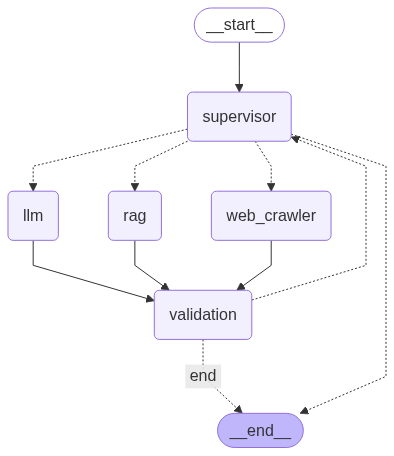

In [14]:
# Visualize the workflow
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph structure:")
    print(app.get_graph())

In [15]:
# Test function
def test_workflow(query: str, max_retries: int = 2):
    """Test the workflow with a given query"""
    print(f"\n{'='*60}")
    print(f"🚀 Testing Query: {query}")
    print(f"{'='*60}\n")
    
    # Initialize state using Pydantic model
    initial_state = WorkflowState(
        query=query,
        max_retries=max_retries
    ).dict()  # Convert to dict for LangGraph compatibility
    
    # Run the workflow
    result = app.invoke(initial_state)
    
    print(f"\n{'='*60}")
    print(f"📋 FINAL RESULT")
    print(f"{'='*60}")
    print(f"Query: {result['query']}")
    print(f"Route: {result['route_decision']}")
    print(f"Validation: {'✅ PASSED' if result['validation_result'] else '❌ FAILED'}")
    print(f"Retries: {result['retry_count']}/{result['max_retries']}")
    print(f"\nFinal Output:\n{result['final_output']}")
    print(f"\n{'='*60}\n")
    
    return result

In [16]:
# Test Case 1: General LLM Query
result1 = test_workflow("What is the capital of France and why is it important?")


🚀 Testing Query: What is the capital of France and why is it important?

🎯 Supervisor Decision: Routing to llm node


/var/folders/bl/xc5d5vc16wx60khkhwlcs3m40000gn/T/ipykernel_93589/3318342660.py:12: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  ).dict()  # Convert to dict for LangGraph compatibility
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


🤖 LLM Response Generated: 1003 characters


❌ Validation FAILED: Validation result: **PASS** 

The response accurately answers the question, providing a clear and comprehensive explanation of Paris's importance as the capital of France.
🔄 Retry attempt 1/2
🎯 Supervisor Decision: Routing to llm node


🤖 LLM Response Generated: 1136 characters


✅ Validation PASSED

📋 FINAL RESULT
Query: What is the capital of France and why is it important?
Route: llm
Validation: ✅ PASSED
Retries: 1/2

Final Output:
The capital of France is **Paris**. 

Here's why it's important:

* **Political Center:** Paris is the seat of the French government, housing the Élysée Palace (presidential residence), the National Assembly, and the Senate. 
* **Cultural Hub:**  Paris is renowned worldwide for its art, fashion, cuisine, and history. It's home to iconic landmarks like the Eiffel Tower, the Louvre Museum, and Notre Dame Cathedral, attracting millions of tourists annually.
* **Economic Powerhouse:** Paris is a major financial and commercial center in Europe, with a thriving business district and a significant influence on global markets.
* **Historical Significance:** Paris has played a pivotal role in French history, witnessing numerous revolutions, wars, and cultural movements. Its rich past is reflected in its architecture, museums, and cultural 

In [17]:
# Test Case 2: RAG Query (AI-related)
result2 = test_workflow("Explain machine learning and its applications in artificial intelligence")


🚀 Testing Query: Explain machine learning and its applications in artificial intelligence

🎯 Supervisor Decision: Routing to rag node


/var/folders/bl/xc5d5vc16wx60khkhwlcs3m40000gn/T/ipykernel_93589/3318342660.py:12: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  ).dict()  # Convert to dict for LangGraph compatibility
/var/folders/bl/xc5d5vc16wx60khkhwlcs3m40000gn/T/ipykernel_93589/927894406.py:10: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  relevant_docs = retriever.get_relevant_documents(query)


📚 RAG Response Generated using 3 documents


✅ Validation PASSED

📋 FINAL RESULT
Query: Explain machine learning and its applications in artificial intelligence
Route: rag
Validation: ✅ PASSED
Retries: 0/2

Final Output:
Machine learning is a type of artificial intelligence (AI) that allows computers to learn from data without being explicitly programmed. 

Instead of relying on specific instructions, machine learning algorithms identify patterns and relationships within data, enabling them to make predictions or decisions. 

Here are some applications of machine learning in AI:

* **Image Recognition:**  As mentioned in the context, computer vision, which uses machine learning, allows machines to "see" and interpret images, identifying objects, faces, and scenes. This is used in applications like self-driving cars, medical imaging analysis, and facial recognition.
* **Natural Language Processing (NLP):** Machine learning powers chatbots, language translation tools, and text summarization software by enabling computers to underst

In [18]:
# Test Case 3: Web Search Query (Current events)
result3 = test_workflow("What are the latest developments in AI technology in 2024?")


🚀 Testing Query: What are the latest developments in AI technology in 2024?

🎯 Supervisor Decision: Routing to web_crawler node


/var/folders/bl/xc5d5vc16wx60khkhwlcs3m40000gn/T/ipykernel_93589/3318342660.py:12: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  ).dict()  # Convert to dict for LangGraph compatibility


🌐 Web Crawler Response Generated using 3 search results


✅ Validation PASSED

📋 FINAL RESULT
Query: What are the latest developments in AI technology in 2024?
Route: web_crawler
Validation: ✅ PASSED
Retries: 0/2

Final Output:
Based on the provided web search results, here are some of the latest developments in AI technology in 2024:

* **Focus on Generative AI:** 2024 has seen significant breakthroughs in Generative AI (GenAI), with advancements influencing various sectors like healthcare, IT, retail, and defense.

* **Multimodal AI:**  Models like Google's Gemini can process not only text but also images and videos, opening up new possibilities for applications.

* **Democratization of AI:** Platforms are emerging that allow users to customize and create their own AI models without coding expertise, making AI more accessible to the general public.

* **Chatbot Explosion:**  Chatbot applications are proliferating, with capabilities like voice cloning, image generation, music making, and realistic video generation.

* **Real-Time AI Insights

In [19]:
# Test Case 4: Custom Query
# For automated testing, using a predefined query instead of input()
custom_query = "What are the latest developments in artificial intelligence?"
if custom_query.strip():
    result4 = test_workflow(custom_query)


🚀 Testing Query: What are the latest developments in artificial intelligence?

🎯 Supervisor Decision: Routing to web_crawler node


/var/folders/bl/xc5d5vc16wx60khkhwlcs3m40000gn/T/ipykernel_93589/3318342660.py:12: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  ).dict()  # Convert to dict for LangGraph compatibility


🌐 Web Crawler Response Generated using 2 search results


✅ Validation PASSED

📋 FINAL RESULT
Query: What are the latest developments in artificial intelligence?
Route: web_crawler
Validation: ✅ PASSED
Retries: 0/2

Final Output:
Here are some of the latest developments in artificial intelligence, based on the provided web search results:

* **Agentic AI:**  AI agents are becoming more sophisticated, capable of making decisions and taking actions autonomously. Google's Gemini 2.0 is a prime example, offering agentic capabilities for developers, enterprises, and individuals. This has implications for various sectors, including banking, healthcare, and even warfare (as seen in Ukraine's "Operation Spider Web").

* **Multi-Modal AI:** AI models are increasingly able to process and understand multiple types of data, such as text, images, and speech. This opens up new possibilities for applications like more natural and intuitive human-computer interaction.

* **Quantum AI:** This emerging field leverages quantum computing to enhance AI algorithms

## Workflow Summary

This implementation includes:

1. **Supervisor Node**: Analyzes queries and routes them to appropriate processing nodes
2. **Router Function**: Intelligent routing based on query content and keywords
3. **Three Processing Nodes**:
   - **LLM Node**: General knowledge and reasoning using Groq
   - **RAG Node**: Knowledge retrieval from local vector database
   - **Web Crawler Node**: Real-time information using Tavily API
4. **Validation Node**: Quality assessment with retry logic
5. **Retry Mechanism**: Automatic retry with supervisor re-routing on validation failure
6. **Final Output**: Validated and approved responses

### Key Features:
- Intelligent routing based on query analysis
- Quality validation with specific criteria
- Retry mechanism with configurable limits
- Real-time web search capabilities
- Local knowledge base integration
- Comprehensive error handling
- Visual workflow representation